Import packages

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import pickle
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

Load data

In [48]:
df = pd.read_csv('elliptic_txs_features.csv', header=None)
df_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
df_classes = pd.read_csv('elliptic_txs_classes.csv')

## 1. Data cleaning

Rename columns

In [49]:
colNames1 = {'0': 'txId', 1: "Timestep"}
colNames2 = {str(i+2): "local" + str(i+1) for i in range(93)}
colNames3 = {str(i+95): "aggregated" + str(i+1) for i in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(j): item_kk for j,item_kk in colNames.items()} 

df = df.rename(columns=colNames)

Rename unknown class and check shapes

In [50]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edgelist.shape)
print('Shape of features', df.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


Check for missing values

In [51]:
# Function to calculate total missing values and percentage
def calculate_missing(df):
    total_missing = df.isna().sum().sum()
    total_cells = df.size
    percentage_missing = (total_missing / total_cells) * 100
    return total_missing, percentage_missing

# Check for missing values in each DataFrame
missing_values_info = []

# For the first DataFrame (df)
missing_values_df, percentage_missing_df = calculate_missing(df)
missing_values_info.append(('df', missing_values_df, f"{percentage_missing_df:.2f}%"))

# For the second DataFrame (df_edgelist)
missing_values_df_edgelist, percentage_missing_df_edgelist = calculate_missing(df_edgelist)
missing_values_info.append(('df_edgelist', missing_values_df_edgelist, f"{percentage_missing_df_edgelist:.2f}%"))

# For the third DataFrame (df_classes)
missing_values_df_classes, percentage_missing_df_classes = calculate_missing(df_classes)
missing_values_info.append(('df_classes', missing_values_df_classes, f"{percentage_missing_df_classes:.2f}%"))

# Create a table using tabulate
print(tabulate(missing_values_info, headers=['DataFrame', 'Total Missing Values', 'Percentage Missing'], tablefmt='fancy_grid'))

╒═════════════╤════════════════════════╤══════════════════════╕
│ DataFrame   │   Total Missing Values │ Percentage Missing   │
╞═════════════╪════════════════════════╪══════════════════════╡
│ df          │                      0 │ 0.00%                │
├─────────────┼────────────────────────┼──────────────────────┤
│ df_edgelist │                      0 │ 0.00%                │
├─────────────┼────────────────────────┼──────────────────────┤
│ df_classes  │                      0 │ 0.00%                │
╘═════════════╧════════════════════════╧══════════════════════╛


Merge the classes to the data

In [52]:
df = pd.merge(df, df_classes)

## 2. EDA

Plot of the distrbution of the classes

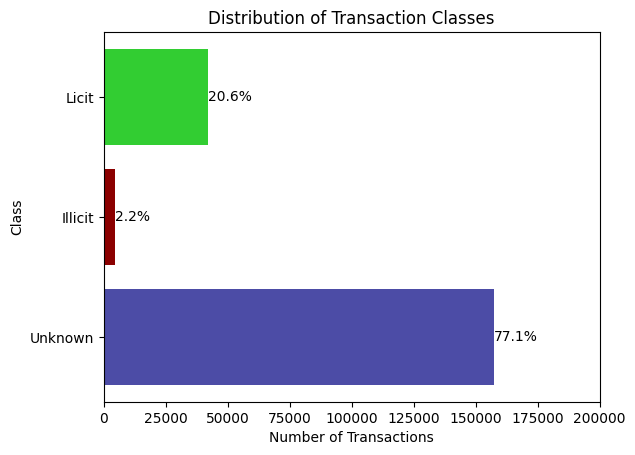

In [53]:
# Custom color palette
colors = [(0, 0, 0.5, 0.7), 'darkred', 'limegreen']

# Grouping by class and counting occurrences
group_class = df_classes.groupby('class').count()

# Calculate total transactions
total_transactions = group_class['txId'].sum()

# Calculate percentages
percentages = (group_class['txId'] / total_transactions) * 100

# Plotting
bars = plt.barh(['Unknown', 'Illicit', 'Licit'], group_class['txId'].values, color=colors)

# Annotate percentages on bars
for bar, p, prc in zip(bars, group_class['txId'].values, percentages):
    plt.text(p, bar.get_y() + bar.get_height()/2, f'{prc:.1f}%', ha='left', va='center', fontsize=10)

# Adding labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Class')
plt.title('Distribution of Transaction Classes')

# Show plot
plt.xlim(0, 200000)
plt.show()

Plot of the transactions per timestep

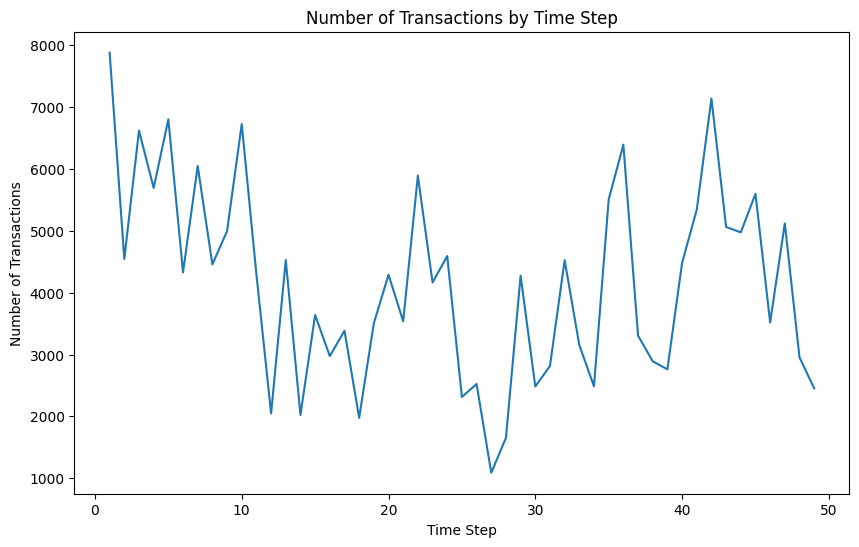

In [54]:
# Grouping by time step and counting occurrences
group_feature = df.groupby(df['Timestep']).count()

# Plotting
group_feature['txId'].plot(figsize=(10, 6))

# Adding labels and title
plt.title('Number of Transactions by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Show plot
plt.show()

Plot of the transactions per timestep per class

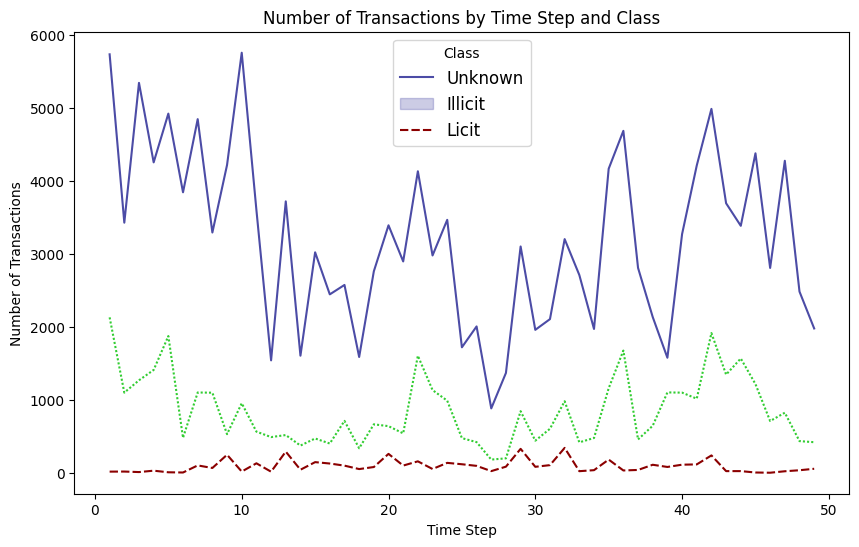

In [55]:
# Grouping by time step and counting occurrences for each class
grouped_df = df.groupby(['Timestep', 'class']).size().unstack(fill_value=0)

# Create figure and axes for line plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting line plot
sns.lineplot(data=grouped_df, palette=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()

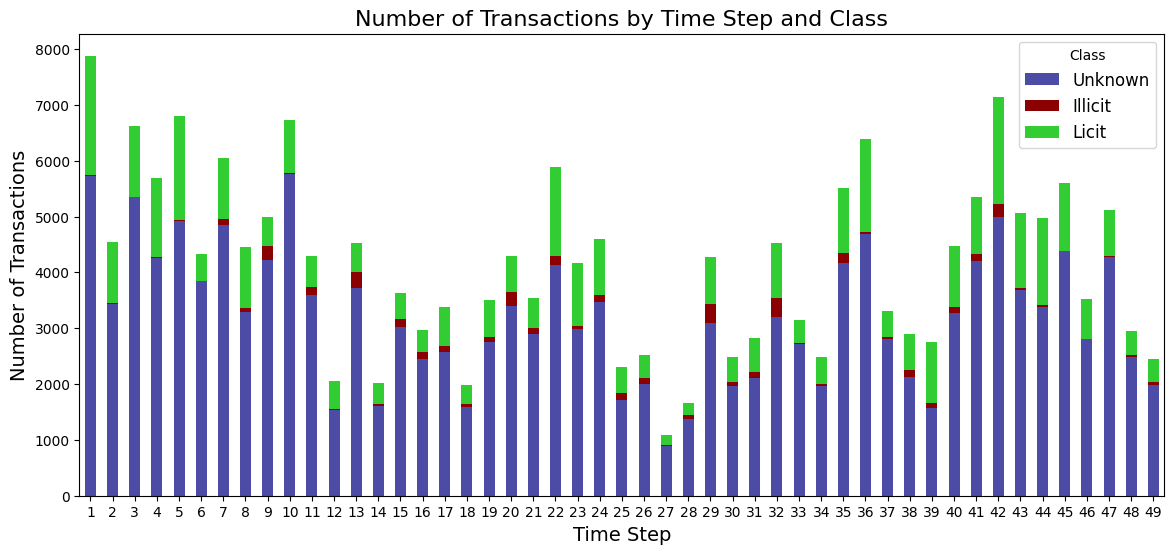

In [56]:
# Create figure and axes for bar plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting bar plot
grouped_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=0) 

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()


Find the most occuring illicit counts per timestep

In [57]:
# Filter DataFrame for illicit transactions
illicit_df = df[df['class'] == '1']

# Group by time step and count occurrences
illicit_count = illicit_df.groupby('Timestep').size()

# Find the three time steps with the highest illicit transaction count
highest_counts = illicit_count.nlargest(3)

# Find the three time steps with the lowest illicit transaction count
lowest_counts = illicit_count.nsmallest(3)

# Convert the series to a DataFrame for tabulation
table_highest = highest_counts.reset_index()
table_highest.columns = ['Time Step', 'Illicit Transaction Count (Highest)']

table_lowest = lowest_counts.reset_index()
table_lowest.columns = ['Time Step', 'Illicit Transaction Count (Lowest)']

# Print tables using tabulate
print("Three time steps with the highest illicit transaction count:")
print(tabulate(table_highest, headers='keys', tablefmt='fancy_grid', showindex=False))
print("\nThree time steps with the lowest illicit transaction count:")
print(tabulate(table_lowest, headers='keys', tablefmt='fancy_grid', showindex=False))

Three time steps with the highest illicit transaction count:
╒═════════════╤═══════════════════════════════════════╕
│   Time Step │   Illicit Transaction Count (Highest) │
╞═════════════╪═══════════════════════════════════════╡
│          32 │                                   342 │
├─────────────┼───────────────────────────────────────┤
│          29 │                                   329 │
├─────────────┼───────────────────────────────────────┤
│          13 │                                   291 │
╘═════════════╧═══════════════════════════════════════╛

Three time steps with the lowest illicit transaction count:
╒═════════════╤══════════════════════════════════════╕
│   Time Step │   Illicit Transaction Count (Lowest) │
╞═════════════╪══════════════════════════════════════╡
│          46 │                                    2 │
├─────────────┼──────────────────────────────────────┤
│           6 │                                    5 │
├─────────────┼─────────────────────────────

Plot the illicit transaction using the edgelist data

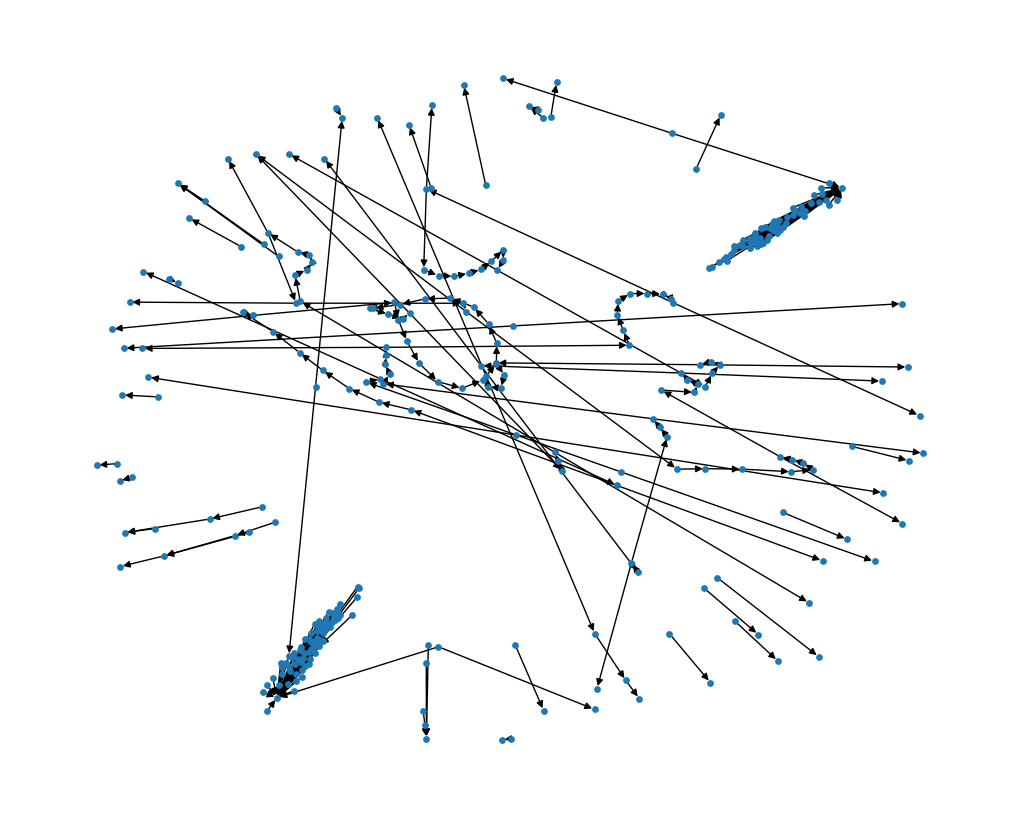

In [58]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 32) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

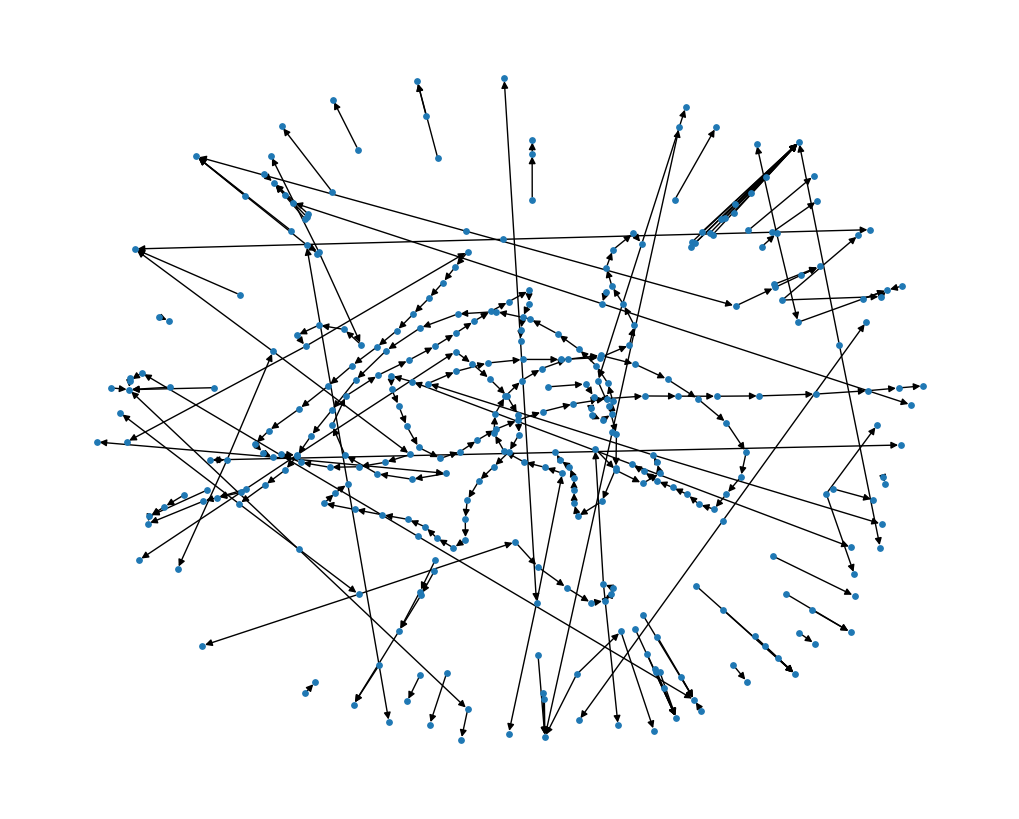

In [59]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 29) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

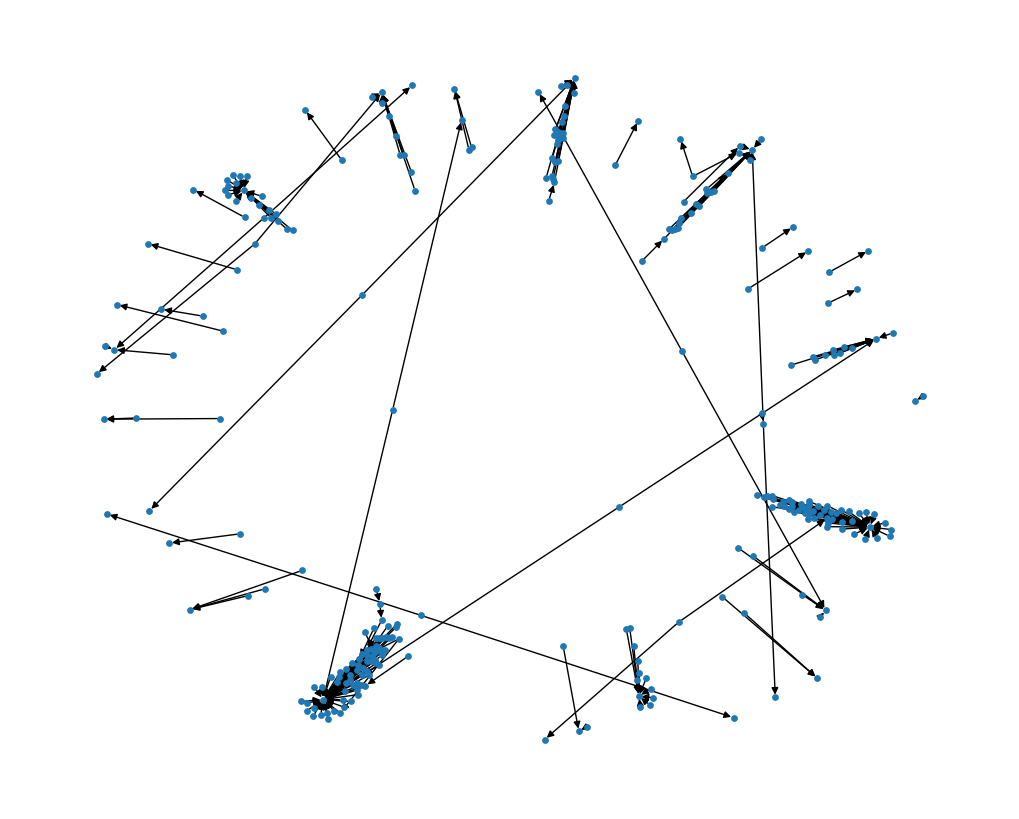

In [60]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 13) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

## 3. Feature engineering

In [61]:
# Make a copy of the DataFrame
df_copy = df.copy()

# Convert 'class' column to integer type in the copy
df_copy['class'] = df_copy['class'].astype(int)

# Calculate the correlation matrix for the copy
correlation_matrix = df_copy.corr()

# Exclude 'txId' and 'Timestep' columns from the correlation matrix
correlation_to_class = correlation_matrix['class'].drop(['txId', 'Timestep', 'class'])

# Sort correlation values in descending order
ranked_features = correlation_to_class.abs().sort_values(ascending=False)

# Extract the top 10 ranked features
top_10_ranked_features = ranked_features.head(10)

# Create a DataFrame with top 10 ranked features
top_10_ranked_features_df = pd.DataFrame({'Rank': range(1, 11), 'Feature': top_10_ranked_features.index, 'Correlation': top_10_ranked_features.values})

# Print the top 10 ranked features using tabulate, ensuring 'Rank' is the first column
print("Top 10 Features based on Correlation with the 'class' column:")
print(tabulate(top_10_ranked_features_df[['Rank', 'Feature', 'Correlation']], headers='keys', tablefmt='fancy_grid', showindex=False))

Top 10 Features based on Correlation with the 'class' column:
╒════════╤═══════════╤═══════════════╕
│   Rank │ Feature   │   Correlation │
╞════════╪═══════════╪═══════════════╡
│      1 │ local53   │      0.4007   │
├────────┼───────────┼───────────────┤
│      2 │ local55   │      0.33205  │
├────────┼───────────┼───────────────┤
│      3 │ local54   │      0.313452 │
├────────┼───────────┼───────────────┤
│      4 │ local52   │      0.248777 │
├────────┼───────────┼───────────────┤
│      5 │ local59   │      0.23266  │
├────────┼───────────┼───────────────┤
│      6 │ local65   │      0.232645 │
├────────┼───────────┼───────────────┤
│      7 │ local60   │      0.21794  │
├────────┼───────────┼───────────────┤
│      8 │ local66   │      0.217926 │
├────────┼───────────┼───────────────┤
│      9 │ local61   │      0.211794 │
├────────┼───────────┼───────────────┤
│     10 │ local67   │      0.211788 │
╘════════╧═══════════╧═══════════════╛


In [62]:
df_copy['class'].describe()

count    203769.000000
mean          2.749182
std           0.482202
min           1.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: class, dtype: float64

In [70]:
# # Make a copy of the original DataFrame
df_copy = df.copy()

# Drop rows with 'class' column value equal to 3
df_copy = df_copy[df_copy['class'] != 3]

columns_to_drop = ['txId', 'Timestep', 'class']

# # Drop columns starting with 'aggregated'
# # columns_to_drop.extend([col for col in df.columns if col.startswith('aggregated')])

df_copy.drop(columns_to_drop, axis=1, inplace=True)

# # Check if the pickle file exists
# if os.path.exists('vif_df.pickle3'):
#     # Load the VIF DataFrame from the pickle file
#     with open('vif_df.pickle3', 'rb') as f:
#         vif_df = pickle.load(f)
# else:
#     def calculate_vif(df):
#         vif_data = pd.DataFrame()
#         vif_data["Feature"] = df_copy.columns
#         vif_data["VIF"] = [variance_inflation_factor(df_copy.values, i) for i in range(len(df_copy.columns))]
#         return vif_data

#     # Calculate VIF for your DataFrame
#     vif_df = calculate_vif(df_copy)
    
#     # Save the VIF DataFrame to a pickle file
#     with open('vif_df.pickle3', 'wb') as f:
#         pickle.dump(vif_df, f)

# # Display the VIF DataFrame
# print(tabulate(vif_df, headers='keys', tablefmt='fancy_grid'))

In [64]:
# # Filter VIF DataFrame to show only values below 10
# vif_df_filtered = vif_df[vif_df['VIF'] < 10]

# # Display the filtered VIF DataFrame
# print(tabulate(vif_df_filtered, headers='keys', tablefmt='fancy_grid'))

In [71]:
# # Get the names of features with VIF values below 10
# selected_features = vif_df_filtered['Feature'].tolist()

# # Keep only the selected features in df_copy
# df_copy = df_copy[selected_features]

# # Display the DataFrame with selected features
df_copy.head()

,local1,local2,local3,local4,local5,local6,local7,local8,local9,local10,...,aggregated63,aggregated64,aggregated65,aggregated66,aggregated67,aggregated68,aggregated69,aggregated70,aggregated71,aggregated72
3,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,-0.047227,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


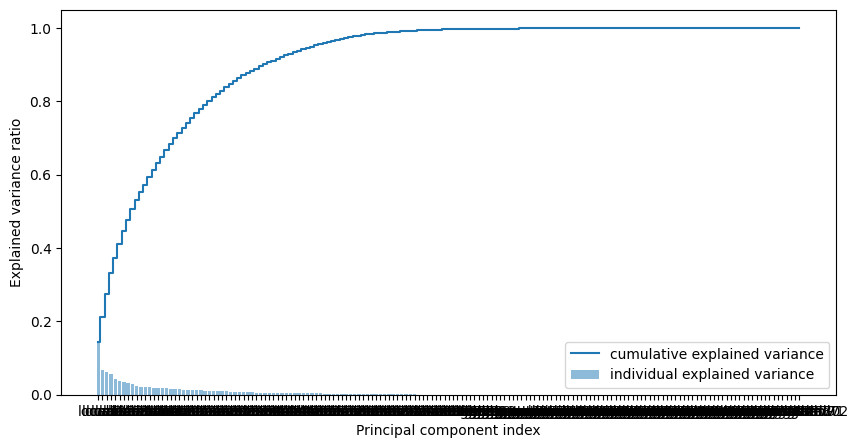

In [72]:
# Perform PCA on the modified DataFrame
pca = PCA()
pca_comps = pca.fit_transform(df_copy) # pca components
var_exp = pca.explained_variance_ratio_ # variance explained ratio 
cum_var_exp = np.cumsum(var_exp) # cumulative variance

# Plot explained variances
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(var_exp) + 1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

# Set column names as x-axis tick labels
plt.xticks(range(1, len(var_exp) + 1), df_copy.columns)

plt.legend(loc='best')
plt.show()


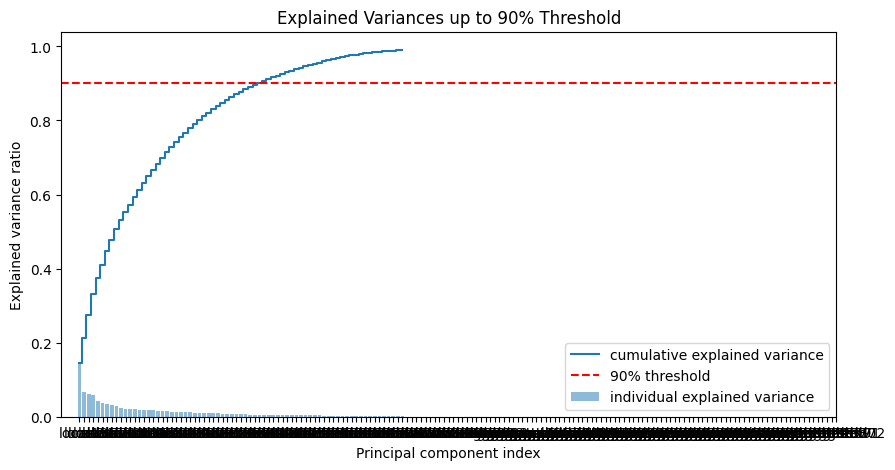

In [76]:
# Calculate the number of components required to explain 90% of variance
n_components_90 = np.argmax(cum_var_exp >= 0.99) + 1

# Plot explained variances up to 80% threshold
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, n_components_90 + 1), var_exp[:n_components_90], alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, n_components_90 + 1), cum_var_exp[:n_components_90], where='mid', label='cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variances up to 90% Threshold')
plt.legend(loc='best')
# Set column names as x-axis tick labels
plt.xticks(range(1, len(var_exp) + 1), df_copy.columns)
plt.show()

In [77]:
# Features to keep based on 90% threshold
most_important_features = df_copy.columns[:n_components_90]

# Create a fancy grid table
table = [["Feature", "Explained Variance Ratio"],
         *zip(most_important_features, var_exp[:n_components_90])]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Save the most important features to a list
most_important_features = list(most_important_features)

╒═══════════╤════════════════════════════╕
│ Feature   │   Explained Variance Ratio │
╞═══════════╪════════════════════════════╡
│ local1    │                0.144725    │
├───────────┼────────────────────────────┤
│ local2    │                0.0674928   │
├───────────┼────────────────────────────┤
│ local3    │                0.0612357   │
├───────────┼────────────────────────────┤
│ local4    │                0.0573888   │
├───────────┼────────────────────────────┤
│ local5    │                0.0424345   │
├───────────┼────────────────────────────┤
│ local6    │                0.037794    │
├───────────┼────────────────────────────┤
│ local7    │                0.0351512   │
├───────────┼────────────────────────────┤
│ local8    │                0.0309456   │
├───────────┼────────────────────────────┤
│ local9    │                0.0285308   │
├───────────┼────────────────────────────┤
│ local10   │                0.0243065   │
├───────────┼────────────────────────────┤
│ local11  

In [78]:
# List of columns to keep in addition to ['txId', 'Timestep', 'class']
columns_to_keep = ['txId', 'Timestep', 'class'] + most_important_features

# Drop columns not in the list of most important features
df_new = df[columns_to_keep]


In [79]:
df_set = df_new.copy()

In [80]:
df_set.head()

,txId,Timestep,class,local1,local2,local3,local4,local5,local6,local7,...,local62,local63,local64,local65,local66,local67,local68,local69,local70,local71
0,230425980,1,3,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-1.316342,-1.315388,-0.039144,-0.172884,-0.163115,-0.160925,-1.316333,-1.315375,-0.017032,-0.030026
1,5530458,1,3,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.923473,0.923011,-0.039146,-0.172884,-0.163114,-0.160926,0.923516,0.923110,-0.017032,-0.030026
2,232022460,1,3,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-1.316342,-1.315388,-0.039136,-0.172859,-0.163090,-0.160900,-1.316333,-1.315375,-0.017032,-0.030025
3,232438397,1,2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.196435,-0.196189,4.629650,0.513869,-0.163115,1.208278,-0.196409,-0.196133,-0.017032,-0.030026
4,230460314,1,3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,0.094039,0.222421,-0.039146,-0.172828,-0.163083,-0.160897,0.094081,0.202143,-0.017032,-0.029992


## 3. Dataset generation

To avoid confusion due to pythons use of the word class, the class column is renamed to class_

In [81]:
# Rename the 'class' column to 'class_'
df_set.rename(columns={'class': 'class_'}, inplace=True)

A traintestsplitter is created based on the three different predicted classes

In [82]:
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        # Drop rows with class_ equal to 3
        df2 = df[df['class_'] != 3]
        self.total_n_illicit = df2.loc[df2['class_'] == 1].shape[0]
        self.total_n_licit = df2.loc[df2['class_'] == 2].shape[0]
        self.train_set = df2.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df2.loc[~df2['txId'].isin(self.train_set['txId'])].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[~self.train_set['txId'].isin(self.validation_set['txId'])].reset_index(drop=True)
        print("Split completed")


The data is split into train, validation and test set. 

In [83]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()
fitting_splits.split_train_test(df_set)

Generating the train/validation/test splits...
Split completed


The split data is once again splitted, this time in x (predictive) and y (predicted) data

In [84]:
# Prepare all the data for subsequent use
# Training Set
X_train = fitting_splits.train_set[fitting_splits.train_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the training set
X_train = X_train.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the training set (square root of selling price)
y_train = fitting_splits.train_set.loc[fitting_splits.train_set['class_'].isin(['1', '2']), 'class_']

# Validation Set
X_validation = fitting_splits.validation_set[fitting_splits.validation_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the validation set
X_validation = X_validation.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the validation set (square root of selling price)
y_validation = fitting_splits.validation_set.loc[fitting_splits.validation_set['class_'].isin(['1', '2']), 'class_']

# Test Set
X_test = fitting_splits.test_set[fitting_splits.test_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the test set
X_test = X_test.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the test set (square root of selling price)
y_test = fitting_splits.test_set.loc[fitting_splits.test_set['class_'].isin(['1', '2']), 'class_']

# Combine Training and Validation Sets for Cross-Validation
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

# Convert the data type of the labels from object to integer
y_train_validation = y_train_validation.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In the following tables, the distribution of classes is shown

In [85]:
# Function to format percentages
def format_percent(percent):
    return "{:.2f} %".format(percent)

count_train = y_train.value_counts()
percent_train = count_train / len(y_train) * 100
table_train = pd.DataFrame({'Count': count_train, 'Percentage': percent_train.map(format_percent)})

count_val = y_validation.value_counts()
percent_val = count_val / len(y_validation) * 100
table_val = pd.DataFrame({'Count': count_val, 'Percentage': percent_val.map(format_percent)})

count_test = y_test.value_counts()
percent_test = count_test / len(y_test) * 100
table_test = pd.DataFrame({'Count': count_test, 'Percentage': percent_test.map(format_percent)})

# Print the tables
print("Training Data:")
print(tabulate(table_train, headers='keys', tablefmt='fancy_grid'))
print("\nValidation Data:")
print(tabulate(table_val, headers='keys', tablefmt='fancy_grid'))
print("\nTest Data:")
print(tabulate(table_test, headers='keys', tablefmt='fancy_grid'))

Training Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │   26923 │ 90.34 %      │
├────┼─────────┼──────────────┤
│  1 │    2878 │ 9.66 %       │
╘════╧═════════╧══════════════╛

Validation Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │    6729 │ 90.32 %      │
├────┼─────────┼──────────────┤
│  1 │     721 │ 9.68 %       │
╘════╧═════════╧══════════════╛

Test Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │    8367 │ 89.84 %      │
├────┼─────────┼──────────────┤
│  1 │     946 │ 10.16 %      │
╘════╧═════════╧══════════════╛


It is desired to have around even distribution of classes in each of the training, test and validation data. As shown in the tables, this is the case.

## 5. Random Forest - Set model Licit/Illicit

This Random Forest is designed to either predict illicit or not illicit. Therefore a binary classification problem is created instead of predicted the three different classes of licit, illicit and unknown. The results are saved in a pickle file, this avoids redoing the hyperparameter tuning process.

In [304]:
# import numpy as np

# # Define the size of the sample
# sample_size = 0.15  # Set your desired sample size, for example, 80% of the data

# # Randomly select a subset of the data for tuning
# indices = np.random.choice(len(X_train_validation), size=int(len(X_train_validation) * sample_size), replace=False)
# X_train_sample = X_train_validation[indices]
# y_train_sample = y_train_validation[indices]

# # Continue with your grid search and pickle logic
# pickle_file = "rf_grid_search_results_binary.pkl"
# if os.path.exists(pickle_file):
#     # Load the results from the pickle file
#     with open(pickle_file, 'rb') as f:
#         grid_search_results = pickle.load(f)
# else:
#     # Perform hyperparameter tuning with cross-validation
#     param_grid = {
#         "n_estimators": [x for x in range(10, 200, 10)],
#         "max_depth": [x for x in range(5, 21, 5)],
#         "min_samples_leaf": [1, 2, 4],
#         "bootstrap": [True, False]
#     }
#     sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
#     sklearn_grid_search_rf.fit(X_train_sample, y_train_sample)
    
#     # Save the results to a pickle file
#     with open(pickle_file, 'wb') as f:
#         pickle.dump(sklearn_grid_search_rf, f)
    
#     grid_search_results = sklearn_grid_search_rf


In [86]:
# Check if the pickle file exists
pickle_file = "rf_grid_search_results.pkl"
if os.path.exists(pickle_file):
    
    # Load the results from the pickle file
    with open(pickle_file, 'rb') as f:
        grid_search_results = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_depth": [x for x in range(5, 21, 5)],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
    sklearn_grid_search_rf.fit(X_train_validation, y_train_validation)
    
    # Save the results to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(sklearn_grid_search_rf, f)
    
    grid_search_results = sklearn_grid_search_rf

In [125]:
# from imblearn.over_sampling import SMOTE

# # Check if the pickle file exists
# pickle_file = "rf_grid_search_results.pkl"
# if os.path.exists(pickle_file):
#     # Load the results from the pickle file
#     with open(pickle_file, 'rb') as f:
#         grid_search_results = pickle.load(f)
# else:
#     # Perform hyperparameter tuning with cross-validation
#     param_grid = {
#         "n_estimators": [x for x in range(10, 200, 10)],
#         "max_depth": [x for x in range(5, 21, 5)],
#         "min_samples_leaf": [1, 2, 4],
#         "bootstrap": [True, False]
#     }
#     sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
    
#     # Apply SMOTE to balance the class distribution
#     smote = SMOTE(random_state=42)
#     X_train_validation_smote, y_train_validation_smote = smote.fit_resample(X_train_validation, y_train_validation)
    
#     # Fit the model with SMOTE balanced data
#     sklearn_grid_search_rf.fit(X_train_validation_smote, y_train_validation_smote)
    
#     # Save the results to a pickle file
#     with open(pickle_file, 'wb') as f:
#         pickle.dump(sklearn_grid_search_rf, f)
    
#     grid_search_results = sklearn_grid_search_rf


In [162]:
# from collections import Counter

# # Check class distribution before SMOTE
# print("Class distribution before SMOTE:", Counter(y_train_validation))

# # Implement SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_validation, y_train_validation)

# # Check class distribution after SMOTE
# print("Class distribution after SMOTE:", Counter(y_train_resampled))


Class distribution before SMOTE: Counter({2: 33645, 1: 3630})
Class distribution after SMOTE: Counter({2: 33645, 1: 33645})


Now, the best hyperparameters are shown following the tuning based on the highest f1 score.

In [87]:
best_random_forest = grid_search_results.best_estimator_

# Prepare data as a list of lists
data = [
    ["Number of Trees", best_random_forest.n_estimators],
    ["Maximum Depth", best_random_forest.max_depth],
    ["Minimum Samples Split", best_random_forest.min_samples_split],
    ["Minimum Samples Leaf", best_random_forest.min_samples_leaf],
    ["Maximum Features", best_random_forest.max_features]
]

# Print table
print(tabulate(data, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))


╒═══════════════════════╤═════════╕
│ Hyperparameter        │ Value   │
╞═══════════════════════╪═════════╡
│ Number of Trees       │ 70      │
├───────────────────────┼─────────┤
│ Maximum Depth         │ 20      │
├───────────────────────┼─────────┤
│ Minimum Samples Split │ 2       │
├───────────────────────┼─────────┤
│ Minimum Samples Leaf  │ 1       │
├───────────────────────┼─────────┤
│ Maximum Features      │ sqrt    │
╘═══════════════════════╧═════════╛


Now let's see what this value of the best F1 score is

In [88]:
best_score = grid_search_results.best_score_

# Prepare data as a list of lists
data = [
    ["Best Score", best_score]
]

# Print table
print(tabulate(data, headers=["Metric", "F1"], tablefmt="fancy_grid"))

╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.907024 │
╘════════════╧══════════╛


To evaluate the model, the accuracy, F1 score, precision and recall are calculate. This is done in percentages to effectively compare it with the research from the paper. The false positive and false negative counts are also added.

In [89]:
# Predict using the trained model
y_hat_test = grid_search_results.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)

# Convert scores to percentages
accuracy_percent = accuracy * 100
f1_percent = f1 * 100
precision_percent = precision * 100
recall_percent = recall * 100

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positives and false negatives
false_positives = fp
false_negatives = fn

# Prepare data as a list of lists
data = [
    ["Accuracy", f"{accuracy_percent:.2f}%"],
    ["F1 Score", f"{f1_percent:.2f}%"],
    ["Precision", f"{precision_percent:.2f}%"],
    ["Recall", f"{recall_percent:.2f}%"],
    ["False Positives", false_positives],
    ["False Negatives", false_negatives]
]

# Print table
print(tabulate(data, headers=["Metric", "Value"], tablefmt="fancy_grid"))


╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 98.24%  │
├─────────────────┼─────────┤
│ F1 Score        │ 90.67%  │
├─────────────────┼─────────┤
│ Precision       │ 98.15%  │
├─────────────────┼─────────┤
│ Recall          │ 84.25%  │
├─────────────────┼─────────┤
│ False Positives │ 149     │
├─────────────────┼─────────┤
│ False Negatives │ 15      │
╘═════════════════╧═════════╛


Now, let's visualize it in a confusion matrix

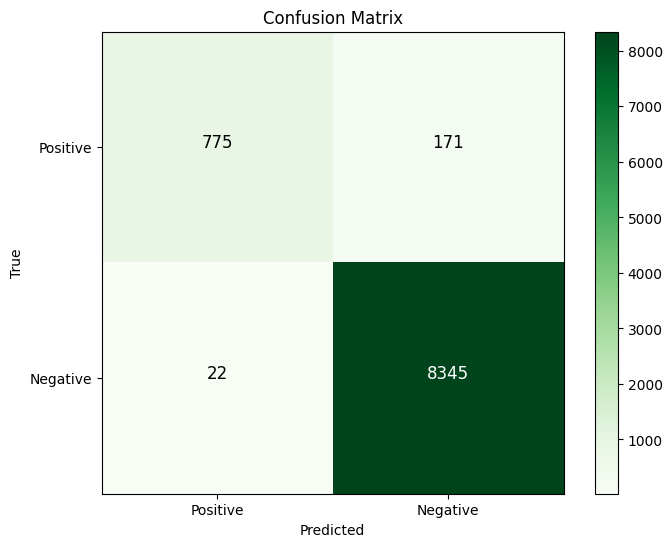

In [308]:
# Get the predicted classes
y_pred = grid_search_results.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define display labels
display_labels = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels)):
    for j in range(len(display_labels)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        plt.text(j, i, format(cm[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels)
plt.yticks(ticks=[0, 1], labels=display_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## 5. Extra trees

This Extra Trees algorithm is designed to either predict illicit or not illicit. Therefore a binary classification problem is created instead of predicted the three different classes of licit, illicit and unknown. The results are saved in a pickle file, this avoids redoing the hyperparameter tuning process.

In [26]:
# Convert the target variable to binary
y_train_validation_binary = (y_train_validation == '1').astype(int)

# Check if the pickle file exists
pickle_file = "et_grid_search_results_binary.pkl"
if os.path.exists(pickle_file):
    # Load the results from the pickle file
    with open(pickle_file, 'rb') as f:
        grid_search_results = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_depth": [x for x in range(5, 21, 5)],
        # "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        # "max_features": ['auto', 'sqrt', 'log2'],
        "bootstrap": [True, False],
        # "class_weight": [None, 'balanced'],
        # "criterion": ['gini', 'entropy']
    }
    sklearn_grid_search_et = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
    sklearn_grid_search_et.fit(X_train_validation, y_train_validation_binary)
    
    # Save the results to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(sklearn_grid_search_et, f)
    
    grid_search_results = sklearn_grid_search_et